<a href="https://colab.research.google.com/github/peeyushsinghal/ContinualLearning/blob/main/EWC_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
%matplotlib inline
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

In [36]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cpu')

In [37]:
# #@title Creating Dataset and Dataloader for MNIST

# torch.manual_seed(1)
# # batch_size = 128
# batch_size = 64

# kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# MNIST_train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=True, download=True,
#                     transform=transforms.Compose([
#                         transforms.ToTensor(),
#                         transforms.Normalize((0.1307,), (0.3081,)) # mean and standard deviation
#                     ])),
#     batch_size=batch_size, shuffle=True, **kwargs)

# MNIST_test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=False, transform=transforms.Compose([
#                         transforms.ToTensor(),
#                         transforms.Normalize((0.1307,), (0.3081,)) # mean and standard deviation
#                     ])),
#     batch_size=batch_size, shuffle=True, **kwargs)

In [38]:
def mnist_imshow(img):
    plt.imshow(img.reshape([28,28]), cmap="gray")
    plt.axis('off')
    plt.show()

In [39]:
# t = 7
# data_point = next(iter(MNIST_train_loader))
# mnist_imshow(data_point[0][t].squeeze())
# print("label : ",data_point[1][t].item())

In [40]:
class PermutedMNIST(datasets.MNIST):

    def __init__(self, root="~/.torch/data/mnist", train=True, permute_idx=None):
        super(PermutedMNIST, self).__init__(root, train, download=True)
        assert len(permute_idx) == 28 * 28
        if self.train:
          # print("data", type(self.train_data),type(self.train_data[0]),self.train_data.shape, self.train_data[0].shape, self.train_data[0])
          self.training_data= torch.stack([img.float().view(-1)[permute_idx] / 255 for img in self.train_data])
          self.training_labels = self.train_labels
        else:
          self.testing_data = torch.stack([img.float().view(-1)[permute_idx] / 255 for img in self.test_data])
          self.testing_labels = self.test_labels

    def __getitem__(self, index):

        if self.train:
            img, target = self.training_data[index], self.training_labels[index]
        else:
            img, target = self.testing_data[index], self.testing_labels[index]

        return img, target

    def get_sample(self, sample_size):
        sample_idx = random.sample(range(len(self)), sample_size)
        return [img for img in self.training_data[sample_idx]]

In [41]:
num_task = 3 # Number of tasks, task 1 we would not have any permutation

In [42]:
def get_permute_mnist():
    train_loader = {}
    test_loader = {}
    idx = list(range(28 * 28)) # first time there is no shuffle
    for i in range(num_task):
        train_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train=True, permute_idx=idx),
                                                      batch_size=batch_size,
                                                      num_workers=4)
        test_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train=False, permute_idx=idx),
                                                     batch_size=batch_size)
        print(f'Index for  task {i} \n {idx}')
        idx = random.sample(idx, len(idx))
    return train_loader, test_loader 


train_loader, test_loader = get_permute_mnist()

Index for  task 0 
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,

 ------task 0 --------
label :  4


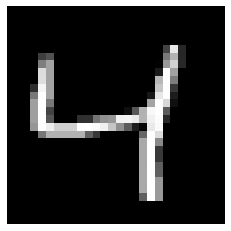

 ------task 1 --------
label :  4


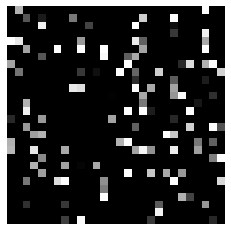

 ------task 2 --------
label :  4


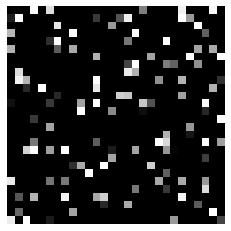

In [46]:
t = 0
for i in range(num_task):
  print(f' ------task {i} --------')
  batch = next(iter(train_loader[i]))
  if t == 0:
    t = random.randint(1,len(batch))
  image, label = batch[0][t], batch[1][t]
  print("label : ", label.item())  
  mnist_imshow(image)


In [44]:
# idx = list(range(28 * 28))
# t = random.randint(1,10)
# data_point = next(iter(MNIST_train_loader))
# data_point_img = data_point[0][t].squeeze()

# for i in range(num_task):
#   print(f' ------task {i} --------')
#   data_point_img = data_point_img.float().view(-1)[idx].view(28,28)
#   print("label : ", data_point[1][t].item())  
#   mnist_imshow(data_point_img)
#   idx = random.sample(idx, len(idx))